<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/agcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
pip install tensorflow_addons

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [20]:
def build_discriminator():
    input_series = layers.Input(shape=(None,1))


    #merged_input = layers.Concatenate()([input_image, digit_embedding_2d])

    # Convolutional layers
    x = layers.Conv1D(128, 2, strides=2 , padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_series)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    # Global pooling
    pooled_output = layers.GlobalAveragePooling1D()(x)

    # Dense layer
    dense_output = layers.Dense(64, activation='relu')(pooled_output)

    # Dense layer
    dense_output = layers.Dense(1, activation='sigmoid')(pooled_output)

    model = tf.keras.models.Model(inputs=input_series, outputs=dense_output)
    return model

discriminator = build_discriminator()
#discriminator_copy = build_discriminator()
discriminator.summary()

# Compile the discriminator model
discriminator.compile(optimizer='adam', loss='mse')

# Generate sample training data with variable-length input sequences
x_train = [
    np.random.randn(np.random.randint(5, 15), 1) for _ in range(1000)
]
y_train = np.random.choice([0, 1], size=(1000,))

# Pad the sequences to a common length
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train)

# Fit the discriminator model to the training data
discriminator.fit(x_train_padded, y_train, epochs=10, batch_size=32)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         384       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, None, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                           

In [37]:
def build_discriminator():
    input_series = layers.Input(shape=(None,1))


    # Generate noise using TensorFlow
    noise = tf.random.normal(shape=tf.shape(input_series))

    # Concatenate noise with input_series
    input_concat = tf.keras.layers.Concatenate()([input_series, noise])

    # Convolutional layers
    x = layers.Conv1D(128, 2, strides=2 , padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)



    # Convolutional layers for output
    x = layers.Conv1D(64, 2, strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Conv1DTranspose layer for upsampling
    x = layers.Conv1DTranspose(1, 2, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    model = tf.keras.models.Model(inputs=input_series, outputs=x)
    return model

discriminator = build_discriminator()
#discriminator_copy = build_discriminator()
discriminator.summary()

# Compile the discriminator model
discriminator.compile(optimizer='adam', loss='mse')

# Generate sample training data with variable-length input sequences
x_train = [
    np.random.randn(np.random.randint(5, 15), 1) for _ in range(1000)
]
y_train = np.random.choice([0, 1], size=(1000,))

# Pad the sequences to a common length
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train)

# Fit the discriminator model to the training data
discriminator.fit(x_train_padded, x_train_padded, epochs=10, batch_size=32)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['input_11[0][0]']               
 )                                                                                                
                                                                                                  
 tf.random.normal (TFOpLambda)  (None, None, 1)      0           ['tf.compat.v1.shape[0][0]']     
                                                                                                  
 concatenate (Concatenate)      (None, None, 2)      0           ['input_11[0][0]',         

In [42]:
# Make predictions on the test dataset
test = np.array([1, 0.4,.4,1,4])
test = test.reshape((1, 5, 1))
test = test.astype('float32') / np.max(test)

predictions = discriminator.predict(test)
print(predictions)

1/1 [==============================] - 0s 27ms/step
[[[ 0.36047426]
  [ 0.14146811]
  [ 0.13315743]
  [ 0.3240518 ]
  [ 1.0349028 ]
  [-0.00900151]]]


In [ ]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)
copy_optimizer = tf.keras.optimizers.Adam(0.0004)

#generator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)
#discriminator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [ ]:
def print_img(generator_model):
    # Generate and save sample images
    noise = tf.random.normal([10, 100])
    sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
    generated_images = generator_model.predict([noise, sampled_labels])
    fig, axs = plt.subplots(1, 10, figsize=(10, 10))
    for i in range(10):
        axs[i].imshow(generated_images[i], cmap="gray")
        axs[i].axis("off")
    plt.show()

disc_loss 1.36118197 gen_loss 0.710824907
disc_loss 1.37134314 gen_loss 0.736392379
disc_loss 1.37862754 gen_loss 0.733660579
disc_loss 1.37404704 gen_loss 0.739466548
disc_loss 1.36673617 gen_loss 0.747378409
disc_loss 1.37303352 gen_loss 0.747132421
disc_loss 1.3538394 gen_loss 0.752221882
disc_loss 1.36178112 gen_loss 0.748219907
disc_loss 1.35800493 gen_loss 0.747447073
disc_loss 1.36810338 gen_loss 0.742636442
Epoch 5/2000000
1/1 [==============================] - 0s 34ms/step


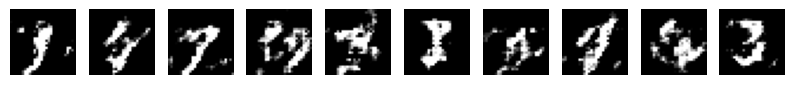

disc_loss 1.34817 gen_loss 0.75177145
disc_loss 1.37163901 gen_loss 0.740327775
disc_loss 1.3546375 gen_loss 0.74761045
disc_loss 1.36259866 gen_loss 0.753030717
disc_loss 1.34997606 gen_loss 0.73922056
disc_loss 1.3599782 gen_loss 0.747205496
disc_loss 1.34485161 gen_loss 0.742138624
disc_loss 1.35266161 gen_loss 0.755974829
disc_loss 1.35477 gen_loss 0.756349206
disc_loss 1.34235692 gen_loss 0.746164143
Epoch 10/2000000
1/1 [==============================] - 0s 33ms/step


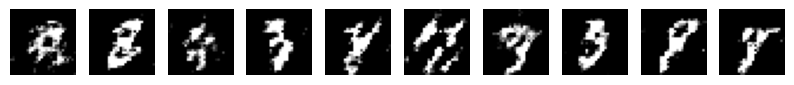

disc_loss 1.34720469 gen_loss 0.762261868
disc_loss 1.36670339 gen_loss 0.760609746
disc_loss 1.36127782 gen_loss 0.7595312
disc_loss 1.35853648 gen_loss 0.764871955
disc_loss 1.34792542 gen_loss 0.757412255
disc_loss 1.35212231 gen_loss 0.758202434
disc_loss 1.34998822 gen_loss 0.765268862
disc_loss 1.34875727 gen_loss 0.768990576
disc_loss 1.33667564 gen_loss 0.764231503
disc_loss 1.34703088 gen_loss 0.770672083
Epoch 15/2000000
1/1 [==============================] - 0s 40ms/step


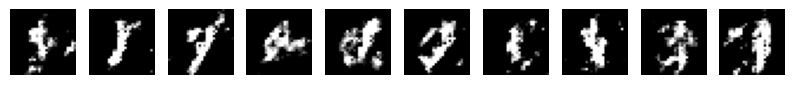

disc_loss 1.35083938 gen_loss 0.76924789
disc_loss 1.36137438 gen_loss 0.74808538
disc_loss 1.32951117 gen_loss 0.766543508
disc_loss 1.34215856 gen_loss 0.759081602
disc_loss 1.33124089 gen_loss 0.76693511
disc_loss 1.33869982 gen_loss 0.773964107
disc_loss 1.33687973 gen_loss 0.776073813
disc_loss 1.3474102 gen_loss 0.771856248
disc_loss 1.33355641 gen_loss 0.766302824
disc_loss 1.32931447 gen_loss 0.776469827
Epoch 20/2000000
1/1 [==============================] - 0s 55ms/step


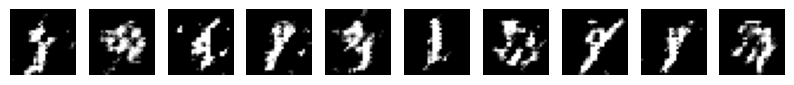

disc_loss 1.33578789 gen_loss 0.769054472
disc_loss 1.34550381 gen_loss 0.775856793
disc_loss 1.32098866 gen_loss 0.782599032
disc_loss 1.33893013 gen_loss 0.777744472
disc_loss 1.33227766 gen_loss 0.774418235
disc_loss 1.34264076 gen_loss 0.758033395
disc_loss 1.32873583 gen_loss 0.775991201
disc_loss 1.33920622 gen_loss 0.77532059
disc_loss 1.32381129 gen_loss 0.77943933
disc_loss 1.33330488 gen_loss 0.784852803
Epoch 25/2000000
1/1 [==============================] - 0s 35ms/step


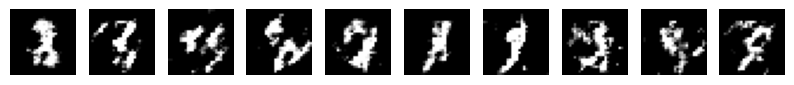

disc_loss 1.31919146 gen_loss 0.775657713
disc_loss 1.3252039 gen_loss 0.778763354
disc_loss 1.31731892 gen_loss 0.779699504
disc_loss 1.33051825 gen_loss 0.783034146
disc_loss 1.3274157 gen_loss 0.789896071
disc_loss 1.33286011 gen_loss 0.784210503
disc_loss 1.31215191 gen_loss 0.780012369
disc_loss 1.32878101 gen_loss 0.784279704
disc_loss 1.30864 gen_loss 0.792546093
disc_loss 1.32434547 gen_loss 0.778921962
Epoch 30/2000000
1/1 [==============================] - 0s 45ms/step


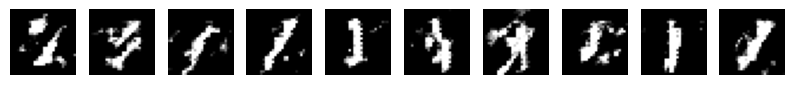

disc_loss 1.32495391 gen_loss 0.777913868
disc_loss 1.33699071 gen_loss 0.779583335
disc_loss 1.30993795 gen_loss 0.785057247
disc_loss 1.33332253 gen_loss 0.791358352
disc_loss 1.31319737 gen_loss 0.795988321
disc_loss 1.32382524 gen_loss 0.798128068
disc_loss 1.31711185 gen_loss 0.797530234
disc_loss 1.32037592 gen_loss 0.780749798
disc_loss 1.30997014 gen_loss 0.786230326
disc_loss 1.32049906 gen_loss 0.80138129
Epoch 35/2000000
1/1 [==============================] - 0s 37ms/step


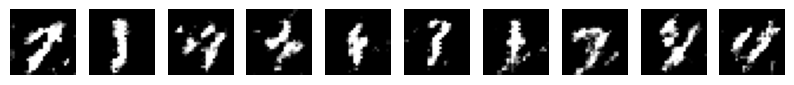

disc_loss 1.29194713 gen_loss 0.793608844
disc_loss 1.33647299 gen_loss 0.786318839
disc_loss 1.314327 gen_loss 0.794182
disc_loss 1.32073462 gen_loss 0.789563537
disc_loss 1.30659866 gen_loss 0.797423184
disc_loss 1.32519722 gen_loss 0.792933285
disc_loss 1.30322123 gen_loss 0.787207
disc_loss 1.31177258 gen_loss 0.779406071
disc_loss 1.29359818 gen_loss 0.797134757
disc_loss 1.31286907 gen_loss 0.795901179
Epoch 40/2000000
1/1 [==============================] - 0s 41ms/step


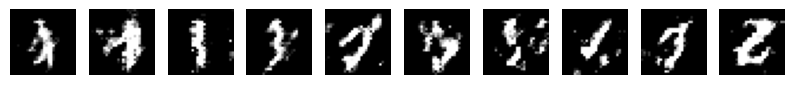

disc_loss 1.30495095 gen_loss 0.802860737
disc_loss 1.30148983 gen_loss 0.800538957
disc_loss 1.29091907 gen_loss 0.80079
disc_loss 1.33136094 gen_loss 0.787449896
disc_loss 1.29641414 gen_loss 0.807343304
disc_loss 1.31518626 gen_loss 0.804796159
disc_loss 1.29380918 gen_loss 0.798545897
disc_loss 1.30820668 gen_loss 0.818193257
disc_loss 1.29800212 gen_loss 0.808982313
disc_loss 1.32421637 gen_loss 0.79912138
Epoch 45/2000000
1/1 [==============================] - 0s 44ms/step


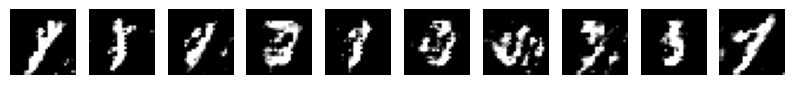

disc_loss 1.28004956 gen_loss 0.786248147
disc_loss 1.30470657 gen_loss 0.780660033
disc_loss 1.28950334 gen_loss 0.801621377
disc_loss 1.31313825 gen_loss 0.794480205
disc_loss 1.2813046 gen_loss 0.809006631
disc_loss 1.31280684 gen_loss 0.799393594
disc_loss 1.29200518 gen_loss 0.790745914
disc_loss 1.29933655 gen_loss 0.802795172
disc_loss 1.2707448 gen_loss 0.804001212
disc_loss 1.30544841 gen_loss 0.804147363
Epoch 50/2000000
1/1 [==============================] - 0s 59ms/step


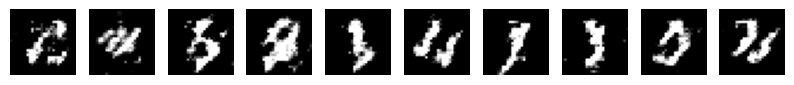

disc_loss 1.2846657 gen_loss 0.799005449
disc_loss 1.29831672 gen_loss 0.790191948


KeyboardInterrupt: ignored

In [25]:
#@tf.function
def train_step(images, labels):

    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])
    generated_images = generator([noise, labels], training=True)



    with tf.GradientTape() as disc_tape:

      real_output = discriminator([images, labels], training=True)
      fake_output = discriminator([generated_images, labels], training=True)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    # Get the weights of model1
    weights = discriminator.get_weights()

    # Set the weights of model2 to be the same as model1
    discriminator_copy.set_weights(weights)

    for i in range(5):
      with tf.GradientTape() as disc_copy_tape:
        noise = tf.random.normal([batch_size, 100])
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator_copy([images, labels], training=True)
        fake_output = discriminator_copy([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_discriminator = disc_copy_tape.gradient(disc_loss, discriminator_copy.trainable_variables)
      copy_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_copy.trainable_variables))



    with tf.GradientTape() as gen_tape:
      noise = tf.random.normal([batch_size, 100])
      generated_images = generator([noise, labels], training=True)
      fake_output = discriminator_copy([generated_images, labels], training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)


def train(generator, discriminator
          , epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(new_images) // batch_size):
            images = new_images[batch * batch_size: (batch+1) * batch_size]
            labels = new_labels[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print_img(generator)

# Train the GAN
EPOCHS = 2000000
BATCH_SIZE = 50
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, EPOCHS, BATCH_SIZE)